# **Libraries and installations**

In [1]:
import SimpleITK as sitk
import itk
import matplotlib.pyplot as plt
import os
import nibabel as nib
import numpy as np
import cv2
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
import scipy.ndimage as ndi

# **Function Definitions**

In [2]:

# Clip wrong/noisy labels
def clip_label(data):
    labels=[]
    for i in range(len(data)):
        label = np.array(data[i])
        label = np.clip(label, 0, 3)
        labels.append(label)
    return labels

# Seperate data per label
def separate_per_label(Data, labels):
    L = []
    unique_labels = np.unique(labels)
    for unique_label in unique_labels:
        label_intensities = Data[labels == unique_label].flatten()
        L.append(label_intensities)
    
    return L

def normalize_mean_std(image):
    img=np.array(image)
    return((img-np.mean(img))/(np.std(img)))

def normalize_min_max(image):
    img=np.array(image)
    return ((img-np.min(img))/(np.max(img)-np.min(img)))*255

def calculate_dice_score(mask1_array, mask2_array, num_classes=4):
    dice_scores = {}
    for label in range(num_classes):
        mask1_class = mask1_array == label
        mask2_class = mask2_array == label
        intersection = np.logical_and(mask1_class, mask2_class).sum()
        mask1_sum = mask1_class.sum()
        mask2_sum = mask2_class.sum()
        dice_score = (2 * intersection) / (mask1_sum + mask2_sum) if (mask1_sum + mask2_sum) > 0 else 1.0
        dice_scores[label] = dice_score
    return dice_scores

def skull_strip(img, label):
    res = np.where(label != 0, 1, 0)
    return img*res

def gaussian_pdf(x, mean, std):
    return norm.pdf(x, mean, std)

# **Registration Using Elastix with affine and Elastic parameters**

In [ ]:
fixed_image_path = r"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Images/1013.nii"
fixed_image = itk.imread(fixed_image_path)

base_path = r"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Images/"
output_directory = r"C:/Users/moham/Downloads"
rigid_params = os.path.join(output_directory, "Parameters.Par0009.affine.txt")
spline_params = os.path.join(output_directory, "Parameters.Par0009.elastic.txt")

parameter_object = itk.ParameterObject.New()
parameter_object.AddParameterFile(rigid_params)
parameter_object.AddParameterFile(spline_params)

registered_images = []
moving_images=[]
parameters = []

for i in range(37):
    # Construct the moving image path
    moving_path = f"{base_path}{'100' if i < 10 else '10'}{i}.nii"

    # Check if the file exists and skip if not
    if not os.path.exists(moving_path) or i == 13:
        continue
    print(f"Processing image {i}...")
    # Read the moving image
    moving_image = itk.imread(moving_path)
    moving_images.append(moving_image)
    # Perform the registration
    registered_image, params = itk.elastix_registration_method(
        fixed_image,
        moving_image,
        parameter_object=parameter_object
    )

    # Store the results
    registered_images.append(registered_image)
    parameters.append(params)

print("Registration completed.")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002036E772150>>
Traceback (most recent call last):
  File "c:\Users\moham\My Files\Education\UDG\CAD\Skin_Binary_Classification\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


In [ ]:
for i in range(100,103):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  axs[0].imshow(registered_images[13][i],cmap="gray")
  axs[0].set_title("registered")

  axs[1].imshow(fixed_image[i],cmap="gray")
  axs[1].set_title("fixed")

  axs[2].imshow(moving_image[i],cmap="gray")
  axs[2].set_title("moving")

  plt.tight_layout()

  plt.show()

In [ ]:
Mask = itk.imread(r"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Labels/1013_3C.nii")
mask2_array = np.asarray(Mask).astype(np.uint8)
registered_masks = []
j = 0

for i in range(37):

    if i < 10:
        moving_path_label = f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Labels/100{i}_3C.nii"
    elif i >= 10:
        moving_path_label = f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Labels/10{i}_3C.nii"

    if not os.path.exists(moving_path_label) or i == 13:
        continue

    moving_mask = itk.imread(moving_path_label)
    transformix = itk.TransformixFilter.New(moving_mask)
    transformix.SetTransformParameterObject(parameters[j])
    transformix.Update()
    transformed_mask = transformix.GetOutput()

    j += 1
    print(f"Mask: {j}")

    transformed_mask_array = np.clip(np.round(itk.GetArrayViewFromImage(transformed_mask)), 0, 3).astype(int)
    
    registered_masks.append(transformed_mask_array)

    dice_scores = calculate_dice_score(transformed_mask_array, mask2_array)
    for label, score in dice_scores.items():
        print(f"Dice score for class {label} in iteration {i}: {score}")


registered_masks_array = np.stack(registered_masks)


In [ ]:
New_moving_image= np.mean(np.stack(registered_images), axis=0)


In [ ]:
# nib.save(nib.Nifti1Image(New_moving_image, nib.load(fixed_image_path).affine, nib.load(fixed_image_path).header),'atlas_image.nii.gz')
# nib.save(nib.Nifti1Image(probability_maps, nib.load(fixed_image_path).affine),'atlas_labels.nii.gz')

In [ ]:
probability_maps = np.zeros((4, 256, 302, 256))

for label in range(4):
    binary_mask = (registered_masks_array == label).astype(int)
    class_count = np.sum(binary_mask, axis=0)

    probability_maps[label] = class_count / 14.0

print("Probability maps shape:", probability_maps.shape)


In [3]:
segmentation_masks = []
Probability_maps=[]
atlas_image=itk.imread("atlas_image_itk2.nii.gz")
moving_mask_from_map=itk.imread("atlas_labels_itk2.nii.gz")


output_directory = r"C:/Users/moham/Downloads"
fixed_path_labels=f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Test/Test/testing-labels"
fixed_path_images=f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Test/Test/testing-images"

rigid_params = os.path.join(output_directory, "Parameters.Par0009.affine.txt")
spline_params = os.path.join(output_directory, "Parameters.Par0009.elastic.txt")

parameter_object = itk.ParameterObject.New()
parameter_object.AddParameterFile(rigid_params)
parameter_object.AddParameterFile(spline_params)

for j,file_name in enumerate(os.listdir(fixed_path_labels)):
    file_path=os.path.join(fixed_path_images,file_name.replace('_3C',''))
    fixed_image = itk.imread(file_path)
    registered_image, params = itk.elastix_registration_method(
        fixed_image,
        atlas_image,
        parameter_object=parameter_object,
    )
    file_path=os.path.join(fixed_path_labels,file_name)
    fixed_label = itk.imread(file_path)
    fixed_label=np.array(fixed_label).astype(np.uint8)
    transformed_mask = []
    for c in range(moving_mask_from_map.shape[0]):
        new_image = itk.image_from_array(moving_mask_from_map[c])
        new_image.CopyInformation(atlas_image)
        transformix = itk.TransformixFilter.New(new_image)
        transformix.SetTransformParameterObject(params)
        transformix.Update()
        transformed_mask.append(transformix.GetOutput())
    print(f"Mask: {j}")
    p_map = np.stack(transformed_mask,0)
    Probability_maps.append(p_map)
    transformed_mask = np.argmax(np.stack(transformed_mask,0),0)
    segmentation_masks.append(transformed_mask)
    dice_scores = calculate_dice_score(transformed_mask, fixed_label)
    for label, score in dice_scores.items():
        print(f"Dice score for class {label} in iteration {j}: {score}")




Mask: 0
Dice score for class 0 in iteration 0: 0.9963253509326169
Dice score for class 1 in iteration 0: 0.5526750256570434
Dice score for class 2 in iteration 0: 0.7770965041817798
Dice score for class 3 in iteration 0: 0.7649105704619267
Mask: 1
Dice score for class 0 in iteration 1: 0.9955773794918279
Dice score for class 1 in iteration 1: 0.7894225514603194
Dice score for class 2 in iteration 1: 0.773237223301294
Dice score for class 3 in iteration 1: 0.7543607249572227
Mask: 2
Dice score for class 0 in iteration 2: 0.9944903203960138
Dice score for class 1 in iteration 2: 0.8085716346327215
Dice score for class 2 in iteration 2: 0.7363948636948845
Dice score for class 3 in iteration 2: 0.7266300050405754
Mask: 3
Dice score for class 0 in iteration 3: 0.9972778500236116
Dice score for class 1 in iteration 3: 0.8190268347882315
Dice score for class 2 in iteration 3: 0.7964231488635398
Dice score for class 3 in iteration 3: 0.7912011854925783
Mask: 4
Dice score for class 0 in iterati

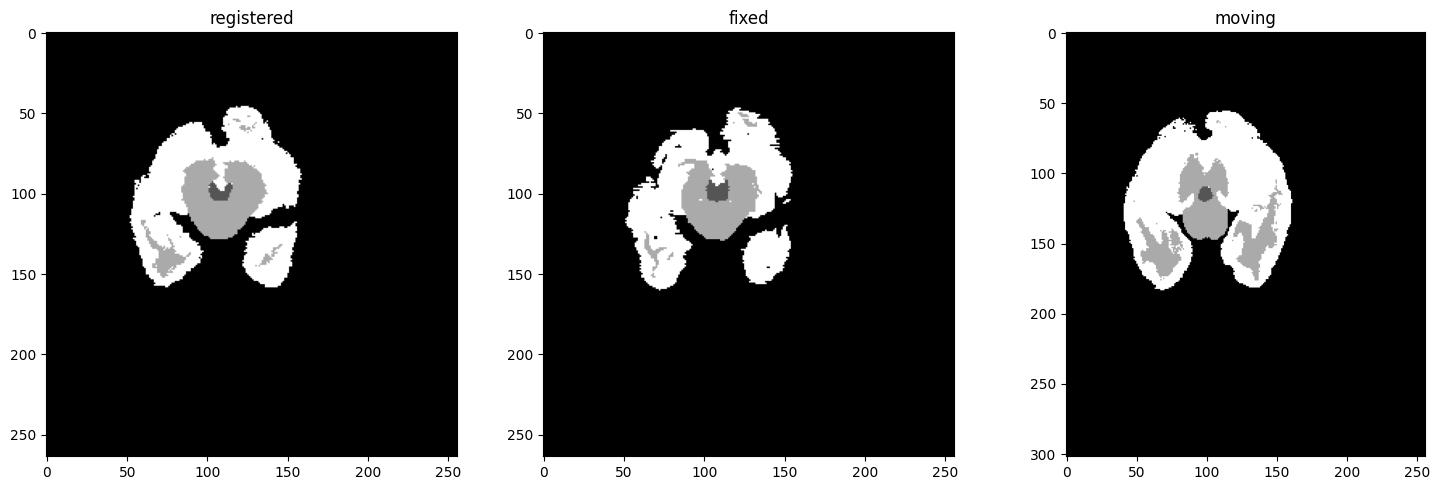

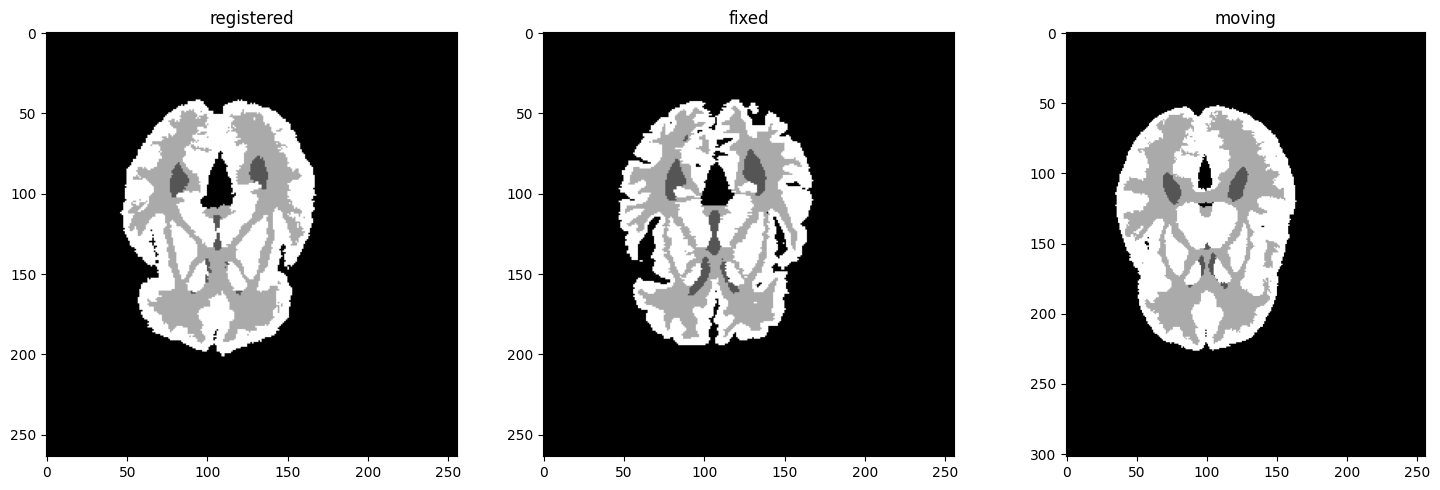

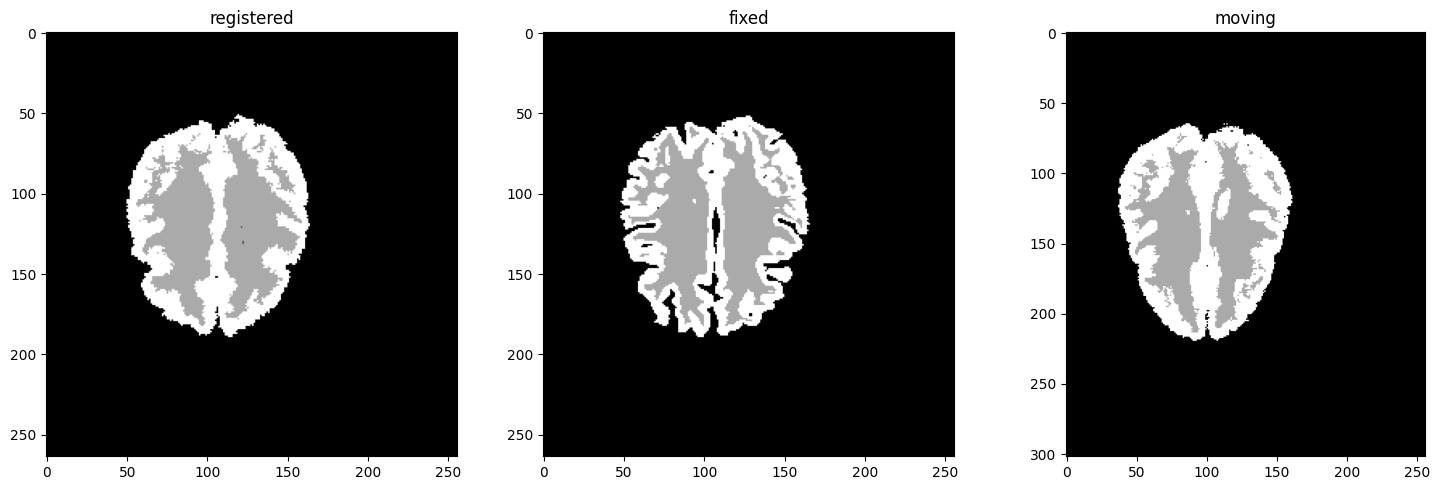

In [6]:
for i in [100,128,156]:
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  axs[0].imshow(segmentation_masks[19][i],cmap="gray")
  axs[0].set_title("registered")

  axs[1].imshow(fixed_label[i],cmap="gray")
  axs[1].set_title("fixed")

  axs[2].imshow(np.argmax(moving_mask_from_map,0)[i],cmap="gray")
  axs[2].set_title("moving")

  plt.tight_layout()

  plt.show()

In [7]:
fixed_path_labels=f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Test/Test/testing-labels"
test_labels=[]
for label in os.listdir(fixed_path_labels):
    test_labelpath=os.path.join(fixed_path_labels,label)
    Label=itk.imread(test_labelpath)
    test_labels.append(Label)


In [8]:
fixed_path_images=f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Test/Test/testing-images"
test_images=[]
for image in os.listdir(fixed_path_images):
    test_labelpath=os.path.join(fixed_path_images,image)
    test_i=itk.imread(test_labelpath)
    test_images.append(test_i)

# **Tissue Models**

In [ ]:
train_paths=[]
train_labels_paths=[]

for i in range(37):
    if i<10:
      train_path=f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Images/100{i}.nii"
      train_label_path=f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Labels/100{i}_3C.nii"
      if os.path.exists(train_path):
        train_paths.append(train_path)
        train_labels_paths.append(train_label_path)

    if i>= 10 :
      train_path=f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Images/10{i}.nii"
      train_label_path=f"C:/Users/moham/My Files/Education/UDG/MISA/Atlas_data/Labels/10{i}_3C.nii"
      if os.path.exists(train_path):
        train_paths.append(train_path)
        train_labels_paths.append(train_label_path)



In [10]:
train_images=[]
train_labels=[]

for i,path in enumerate(train_paths):
    image = itk.imread(path)
    train_images.append(image)
    
for i,path in enumerate(train_labels_paths):
    image = itk.imread(path)
    train_labels.append(image)

clipped_labels=clip_label(train_labels)


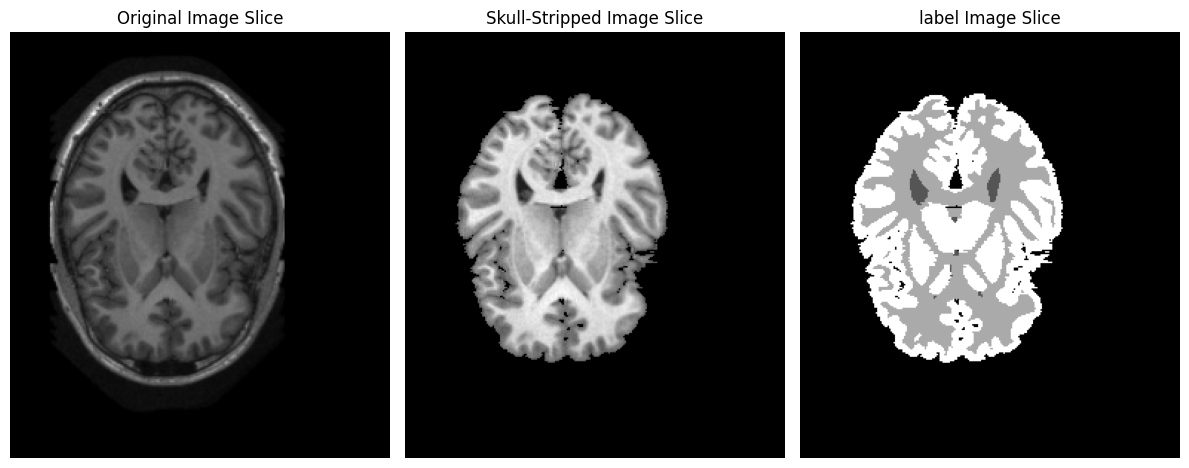

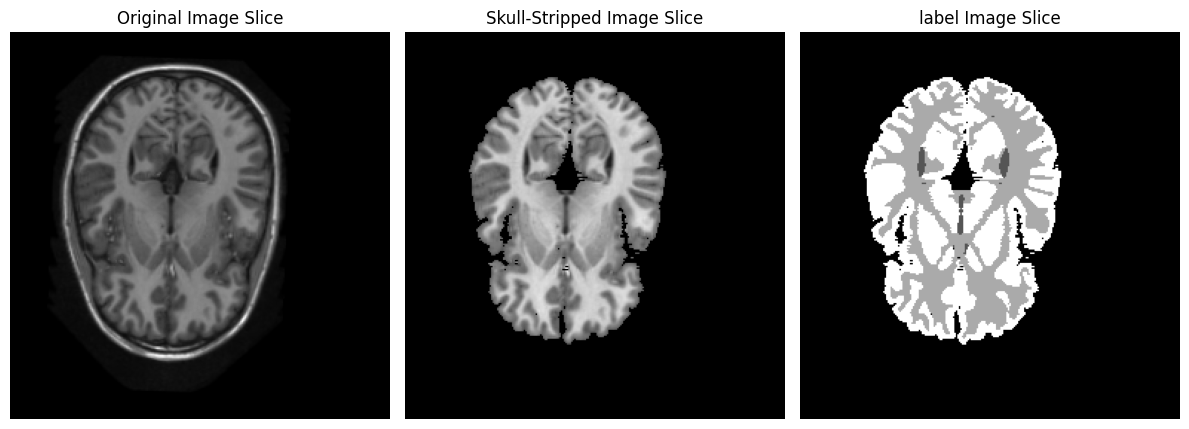

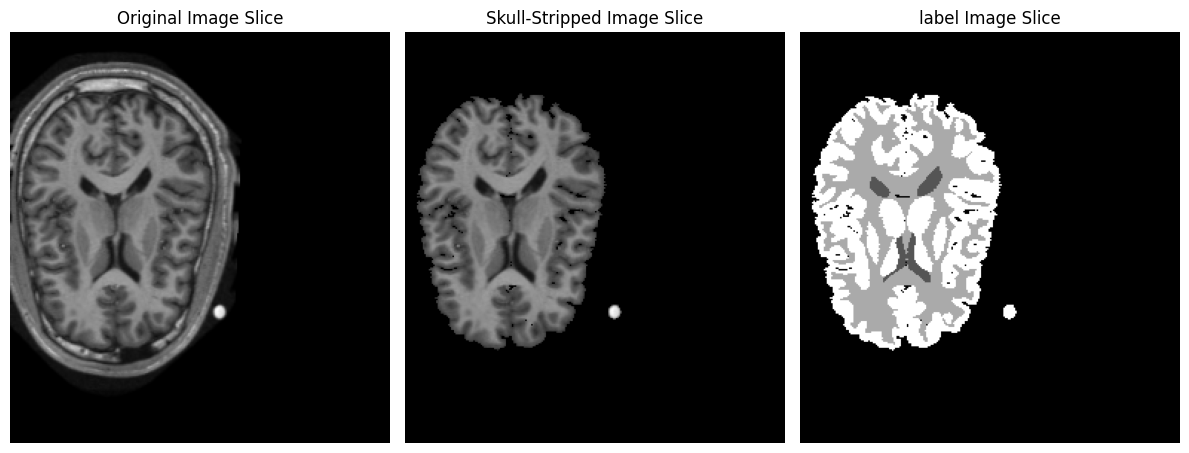

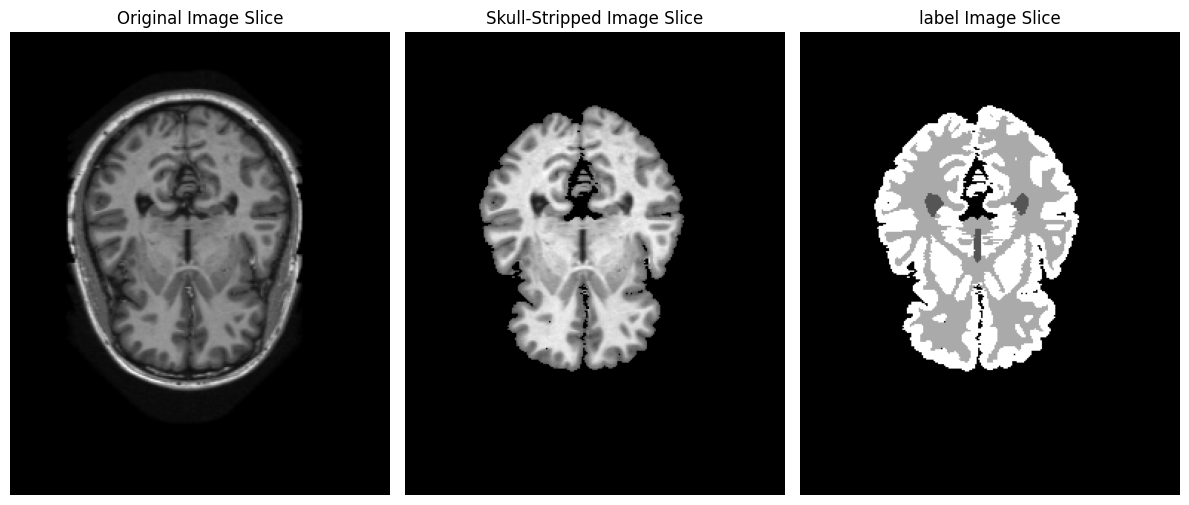

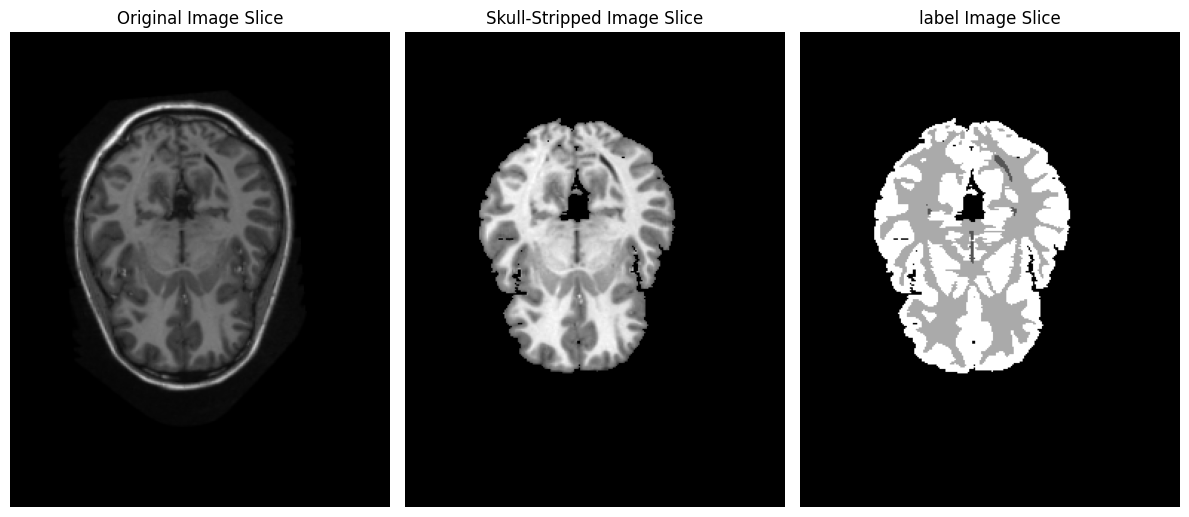

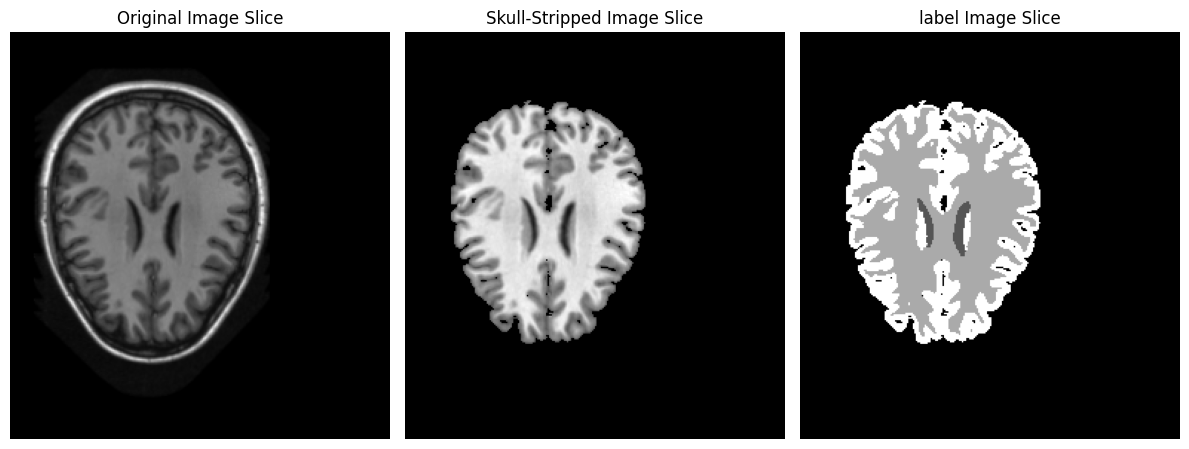

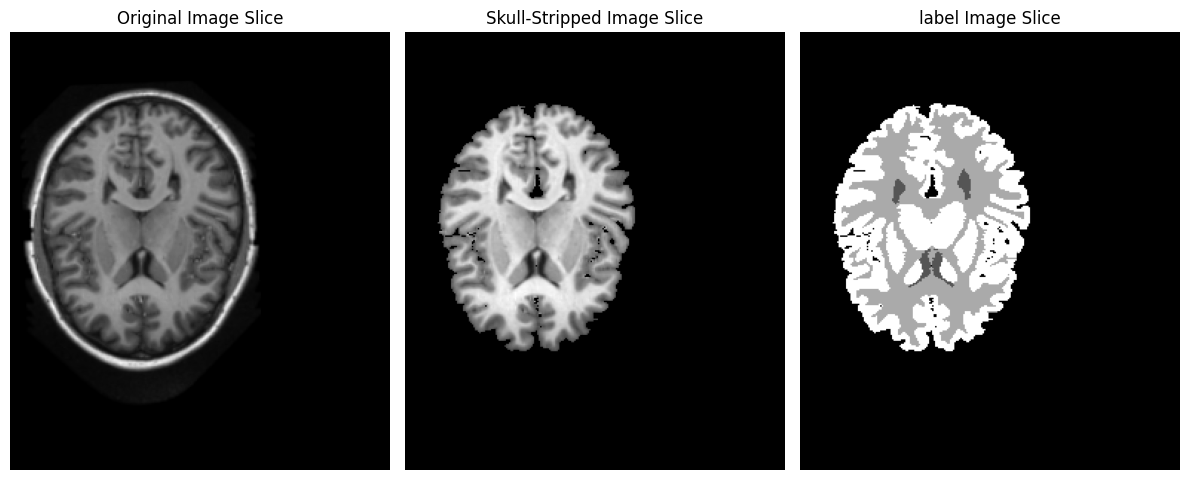

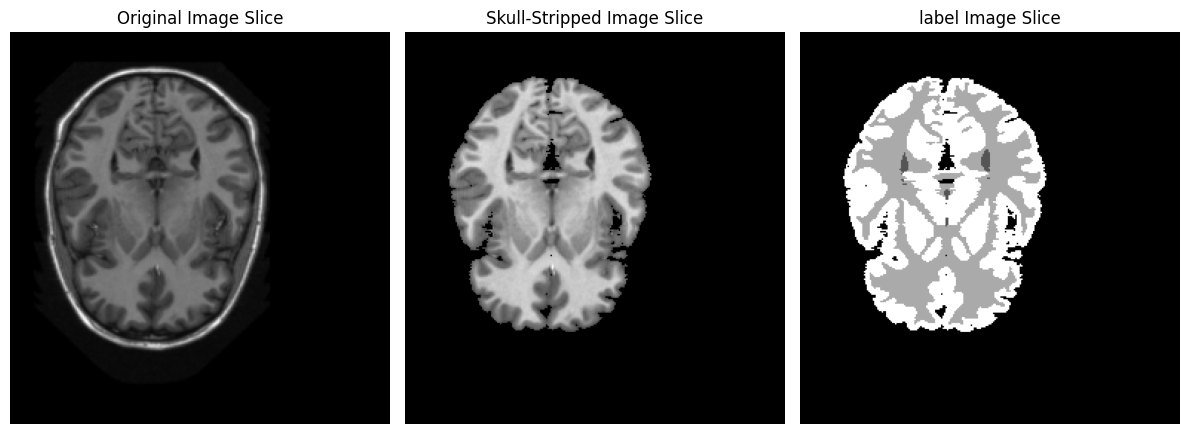

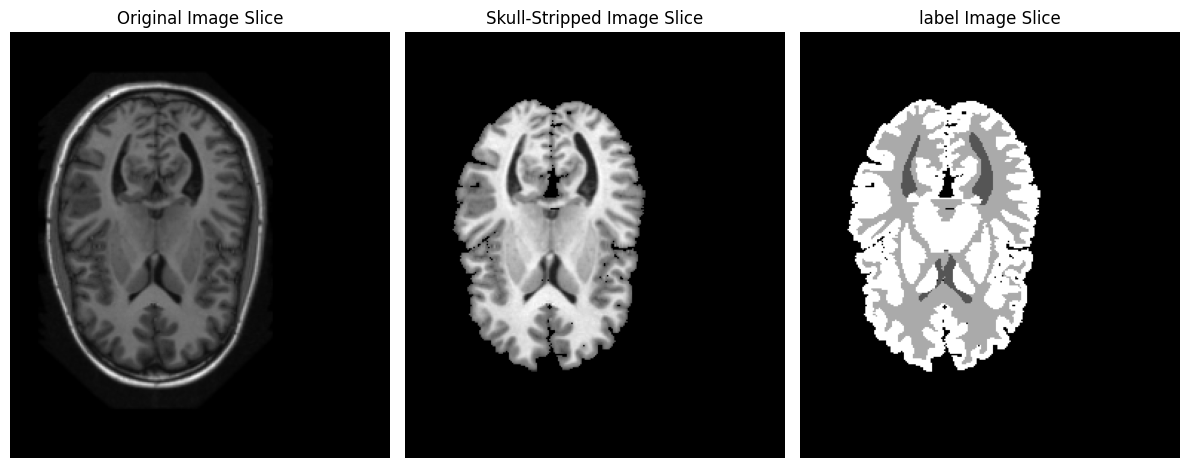

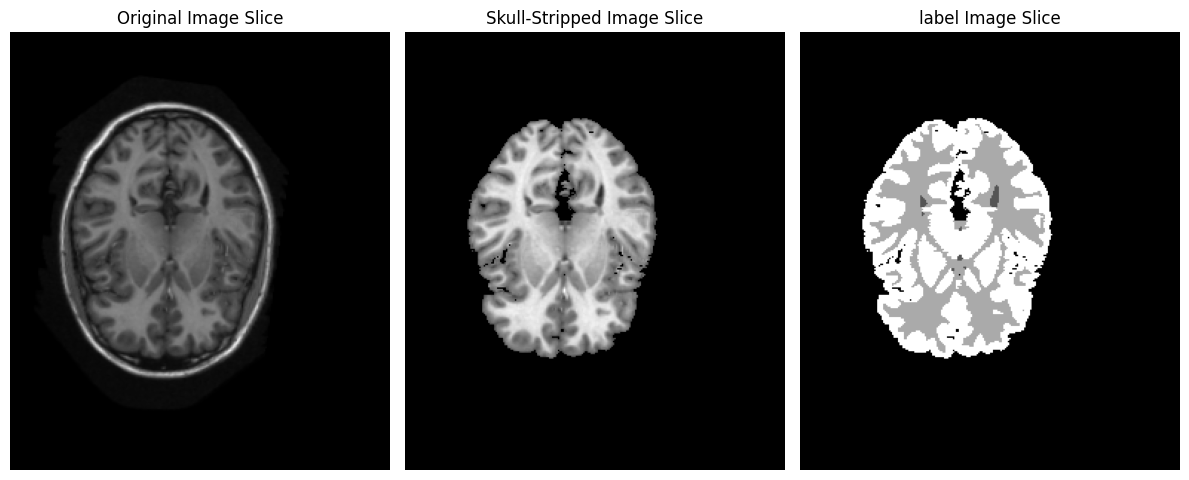

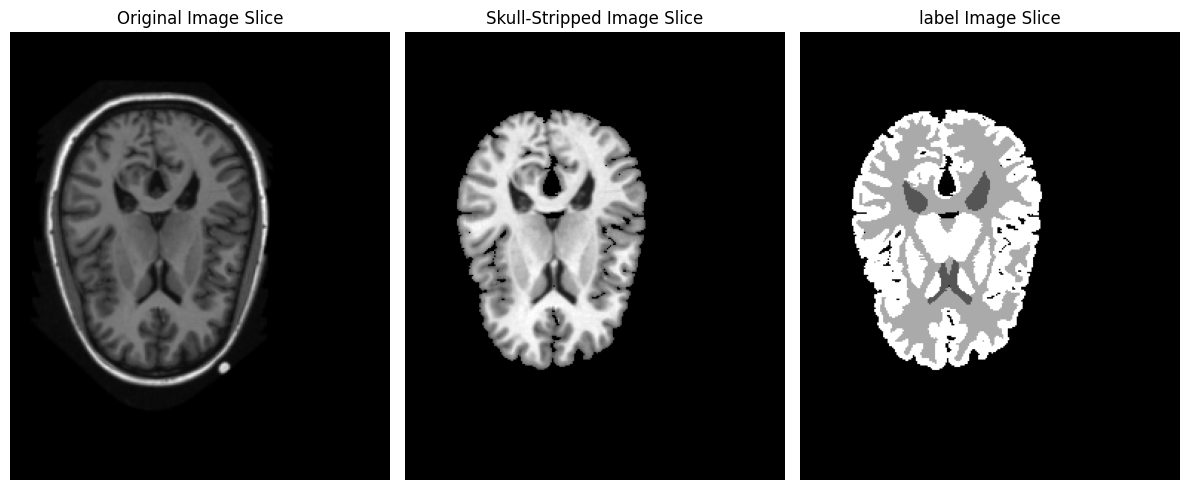

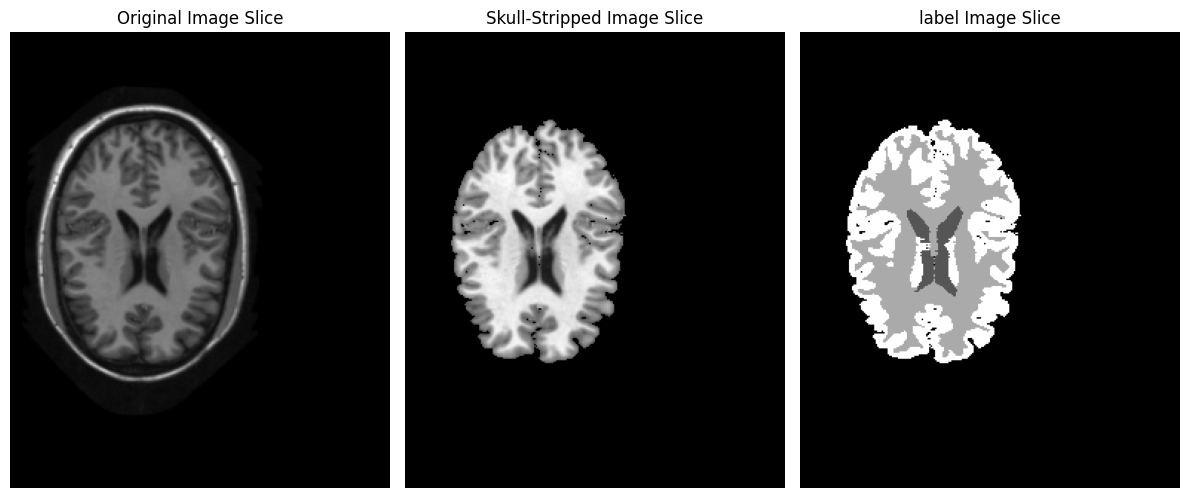

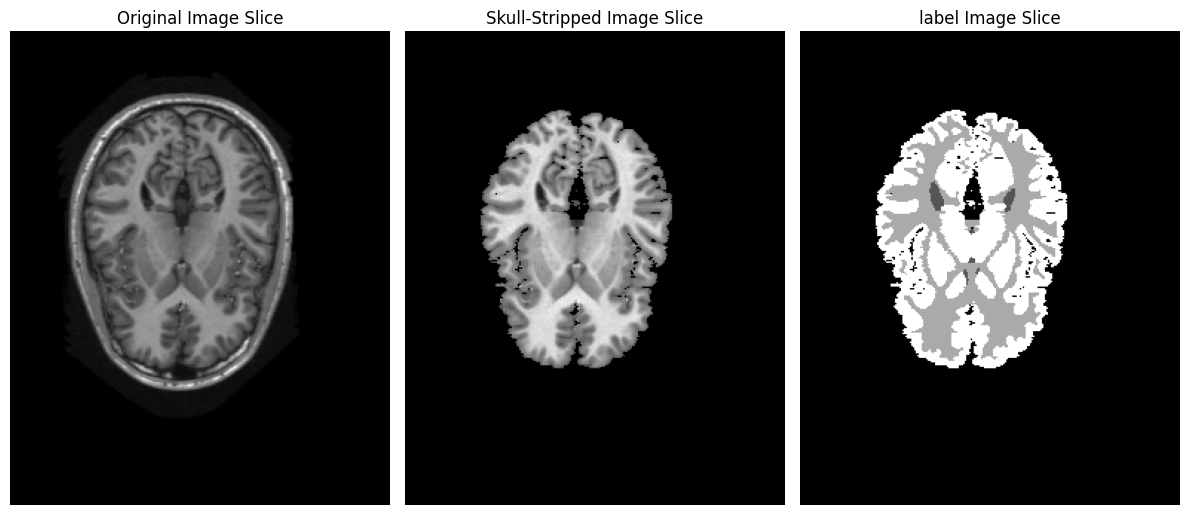

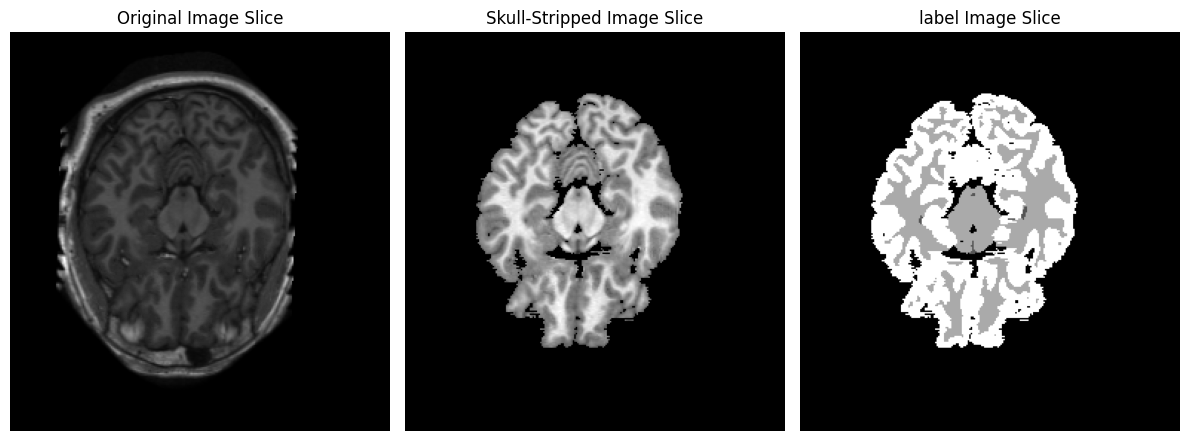

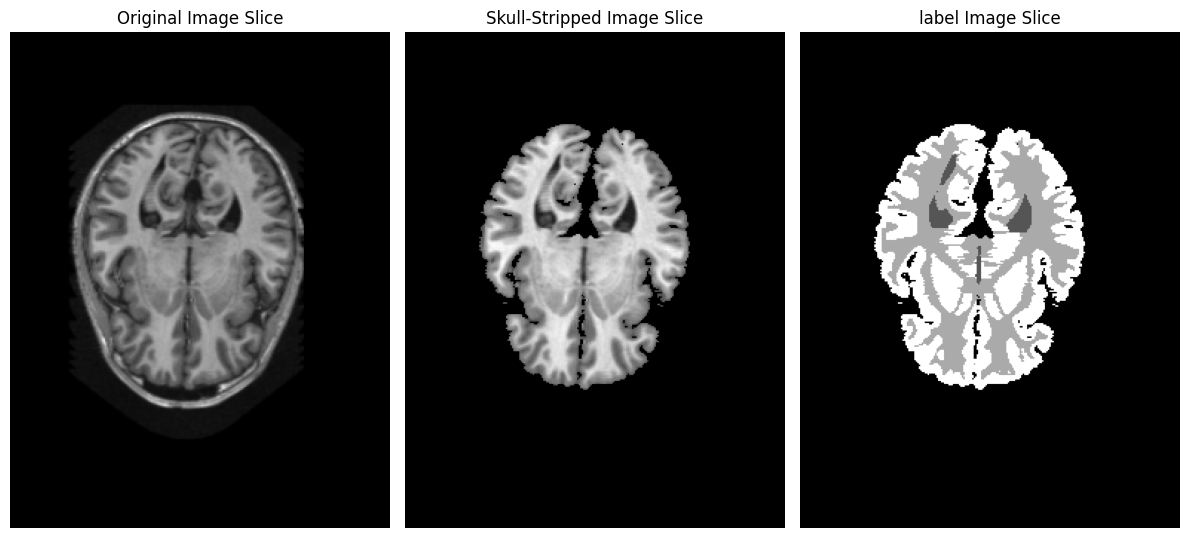

In [ ]:
skull_stripped = []

for i in range(len(clipped_labels)):
    image = train_images[i]
    label = clipped_labels[i]

    stripped = skull_strip(image, label)

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(image[130], cmap='gray')
    axes[0].set_title("Original Image Slice")
    axes[0].axis('off')

    axes[1].imshow(stripped[130], cmap='gray')
    axes[1].set_title("Skull-Stripped Image Slice")
    axes[1].axis('off')

    axes[2].imshow(label[130], cmap='gray')
    axes[2].set_title("label Image Slice")
    axes[2].axis('off')


    plt.tight_layout()
    plt.show()

    skull_stripped.append(stripped)


In [ ]:
Normalized0, Normalized1, Normalized2, Normalized3 = [], [], [], []

for i in range(len(clipped_labels)):
    L = separate_per_label(skull_stripped[i], clipped_labels[i])
    
    Normalized0.append(L[0])  
    Normalized1.append(normalize_min_max(L[1]))
    Normalized2.append(normalize_min_max(L[2]))
    Normalized3.append(normalize_min_max(L[3]))

In [ ]:
Histograms0 = []
Histograms1 = []
Histograms2 = []
Histograms3 = []

for i in range(len(Normalized1)):
    histogram0, _ = np.histogram(Normalized0[i], bins=255,range=(0,1))
    histogram1, _ = np.histogram(Normalized1[i], bins=255)
    histogram2, _ = np.histogram(Normalized2[i], bins=255)
    histogram3, _ = np.histogram(Normalized3[i], bins=255)
    Histograms0.append(histogram0)
    Histograms1.append(histogram1)
    Histograms2.append(histogram2)
    Histograms3.append(histogram3)

Histograms0 = np.array(Histograms0)
Histograms1 = np.array(Histograms1)
Histograms2 = np.array(Histograms2)
Histograms3 = np.array(Histograms3)


Total_Hist0 = np.sum(Histograms0, axis=0).astype(float)
Total_Hist1 = np.sum(Histograms1, axis=0).astype(float)
Total_Hist2 = np.sum(Histograms2, axis=0).astype(float)
Total_Hist3 = np.sum(Histograms3, axis=0).astype(float)

tot =  (Total_Hist1+Total_Hist2+Total_Hist3)
Total_Hist1 /= tot
Total_Hist2 /= tot
Total_Hist3 /= tot

smoothed_hist1 = ndi.gaussian_filter1d(Total_Hist1, sigma=2)
smoothed_hist2 = ndi.gaussian_filter1d(Total_Hist2, sigma=2)
smoothed_hist3 = ndi.gaussian_filter1d(Total_Hist3, sigma=2)

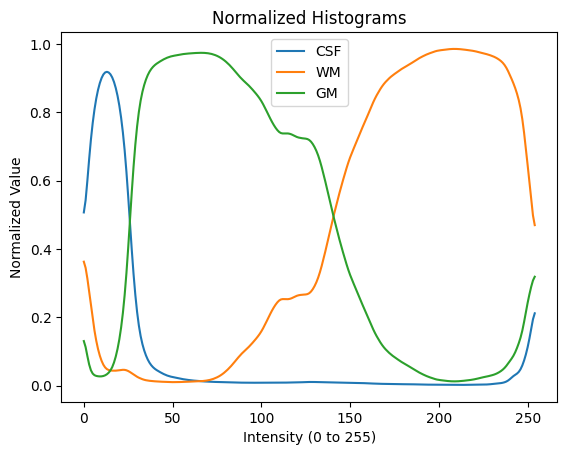

In [ ]:
num_bins = 255
bin_width = 1 / num_bins
bin_midpoints = np.linspace(bin_width / 2, 1 - bin_width / 2, num_bins)

plt.plot(smoothed_hist1, label='CSF')
plt.plot(smoothed_hist2, label='WM')
plt.plot(smoothed_hist3, label='GM')

plt.xlabel("Intensity (0 to 255)")
plt.ylabel("Normalized Value")
plt.legend()
plt.title("Normalized Histograms")
plt.show()

In [15]:
test_image_path=r"C:\Users\moham\My Files\Education\UDG\MISA\Atlas_data\Test\Test\testing-images"
test_label_path=r"C:\Users\moham\My Files\Education\UDG\MISA\Atlas_data\Test\Test\testing-labels"
predictions=[]
test_labels=[]
for file_name in os.listdir(test_image_path):
    for label_file_name in os.listdir(test_label_path):
        if label_file_name[:4] == file_name[:4]:
            test_path=os.path.join(test_image_path,file_name)
            label_path=os.path.join(test_label_path,label_file_name)
            test_image = np.array(itk.imread(test_path))
            test_label= np.array(itk.imread(label_path))
            test_labels.append(test_label)
            test_image = skull_strip(test_image, test_label)
            normalized_test = (test_image-test_image.min())/(test_image.max()-test_image.min())
            prediction_T = np.zeros_like(normalized_test)
            foreground_mask = test_label >0
            indices = np.clip((normalized_test[foreground_mask] * (num_bins -1)).astype(int), 0, num_bins-1)
            prediction_T[foreground_mask] = np.argmax([
                Total_Hist0[indices],
                50*smoothed_hist1[indices],
                smoothed_hist2[indices],
                smoothed_hist3[indices],

            ], axis=0)
            predictions.append(prediction_T)


In [ ]:
dice_scores_class_0 = []
dice_scores_class_1 = []
dice_scores_class_2 = []
dice_scores_class_3 = []

for i in range(len(os.listdir(test_image_path))):
    dice_scores = calculate_dice_score(test_labels[i],predictions[i])

    dice_scores_class_0.append(dice_scores[0])
    dice_scores_class_1.append(dice_scores[1])
    dice_scores_class_2.append(dice_scores[2])
    dice_scores_class_3.append(dice_scores[3])

mean_0, std_0 = np.mean(dice_scores_class_0), np.std(dice_scores_class_0)
mean_1, std_1 = np.mean(dice_scores_class_1), np.std(dice_scores_class_1)
mean_2, std_2 = np.mean(dice_scores_class_2), np.std(dice_scores_class_2)
mean_3, std_3 = np.mean(dice_scores_class_3), np.std(dice_scores_class_3)

print(f"Class 0: Mean = {mean_0:.4f}, Std = {std_0:.4f}")
print(f"Class 1: Mean = {mean_1:.4f}, Std = {std_1:.4f}")
print(f"Class 2: Mean = {mean_2:.4f}, Std = {std_2:.4f}")
print(f"Class 3: Mean = {mean_3:.4f}, Std = {std_3:.4f}")

Class 0: Mean = 1.0000, Std = 0.0000
Class 1: Mean = 0.6196, Std = 0.1640
Class 2: Mean = 0.8389, Std = 0.0529
Class 3: Mean = 0.8815, Std = 0.0495


# **Combining Label Propagation and Tissue Models**

In [ ]:
test_image_path = r"C:\Users\moham\My Files\Education\UDG\MISA\Atlas_data\Test\Test\testing-images"
test_label_path = r"C:\Users\moham\My Files\Education\UDG\MISA\Atlas_data\Test\Test\testing-labels"

predictions = []
test_labels = []

max_intensity = len(Total_Hist0) - 1 

for i, file_name in enumerate(sorted(os.listdir(test_image_path))):
    for label_file_name in sorted(os.listdir(test_label_path)):
        if label_file_name[:4] == file_name[:4]:
            test_path = os.path.join(test_image_path, file_name)
            label_path = os.path.join(test_label_path, label_file_name)
            
            test_image = np.array(itk.imread(test_path))
            test_label = np.array(itk.imread(label_path))
            test_labels.append(test_label)
            
            test_image = skull_strip(test_image, test_label)
            normalized_test = (test_image - test_image.min()) / (test_image.max() - test_image.min())
            
            foreground_mask = test_label > 0
            
            image_indices = np.clip((normalized_test * max_intensity).astype(int), 0, max_intensity)
            
            prob_map0 = np.zeros_like(normalized_test)
            prob_map1 = np.zeros_like(normalized_test)
            prob_map2 = np.zeros_like(normalized_test)
            prob_map3 = np.zeros_like(normalized_test)

            prob_map0[foreground_mask] = Total_Hist0[image_indices[foreground_mask]]
            prob_map1[foreground_mask] = smoothed_hist1[image_indices[foreground_mask]]
            prob_map2[foreground_mask] = smoothed_hist2[image_indices[foreground_mask]]
            prob_map3[foreground_mask] = smoothed_hist3[image_indices[foreground_mask]]
            
            combined_prob_map = np.zeros((4, *test_image.shape), dtype=np.float32)
            
            combined_prob_map[0] = Probability_maps[i][0] * prob_map0
            combined_prob_map[1] = Probability_maps[i][1] * prob_map1
            combined_prob_map[2] = Probability_maps[i][2] * prob_map2
            combined_prob_map[3] = Probability_maps[i][3] * prob_map3
            
            sum_prob_map = combined_prob_map.sum(axis=0, keepdims=True)
            sum_prob_map[sum_prob_map == 0] = 1 
            combined_prob_map /= sum_prob_map
            
            segmentation = np.argmax(combined_prob_map, axis=0)
            predictions.append(segmentation)

            dice_score = calculate_dice_score(segmentation, test_label)
            dice_scores = {k: float(v) for k, v in dice_score.items()}
            print("Dice Scores:", dice_scores)


Dice Scores: {0: 0.9999386199450324, 1: 0.5759550274690175, 2: 0.8458015707439239, 3: 0.9112113264020657}
Dice Scores: {0: 0.9999639824898101, 1: 0.7018482490272373, 2: 0.8885768594897978, 3: 0.9132767733129701}
Dice Scores: {0: 0.9999856340265656, 1: 0.7719111042129464, 2: 0.8409552349097007, 3: 0.8775844368494237}
Dice Scores: {0: 0.9999964295523055, 1: 0.6993683781581093, 2: 0.8898354656307651, 3: 0.9309772537302815}
Dice Scores: {0: 0.9999878826350295, 1: 0.6494585373090046, 2: 0.8835206372146709, 3: 0.9239194620240856}
Dice Scores: {0: 0.9999477565778339, 1: 0.6185471610813669, 2: 0.8822349647617286, 3: 0.9256329571271387}
Dice Scores: {0: 0.9999533977916867, 1: 0.7048097251585623, 2: 0.865289746434746, 3: 0.9012991489992824}
Dice Scores: {0: 0.9999801914878883, 1: 0.7692099357734272, 2: 0.8561886651027858, 3: 0.9010219375440084}
Dice Scores: {0: 0.9999983118305654, 1: 0.6097364046544763, 2: 0.8994469330262282, 3: 0.9274837608850041}
Dice Scores: {0: 0.9999839964553403, 1: 0.64354

**Table of dice scores**

# **Calculations for Label Prop Inintialization for EM**

In [ ]:
test_image_path = r"C:\Users\moham\My Files\Education\UDG\MISA\Atlas_data\Test\Test\testing-images"
Means_label_prop=[]
std_label_prop=[]
for i, file_name in enumerate(sorted(os.listdir(test_image_path))):
    for label_file_name in sorted(os.listdir(test_label_path)):
        if label_file_name[:4] == file_name[:4]:
            test_path = os.path.join(test_image_path, file_name)
            test_image=itk.imread(test_path)
            segmented_image = segmentation_masks[i]
            test_image_normalized=(test_image-np.min(test_image))/(np.max(test_image)-np.min(test_image))
            mean_label_1 = np.mean(test_image_normalized[segmented_image == 1])
            std_label_1 = np.std(test_image_normalized[segmented_image == 1])
            mean_label_2 = np.mean(test_image_normalized[segmented_image == 2])
            std_label_2 = np.std(test_image_normalized[segmented_image == 2])
            mean_label_3 = np.mean(test_image_normalized[segmented_image == 3])
            std_label_3 = np.std(test_image_normalized[segmented_image == 3])
            Means_label_prop.append([[mean_label_1],[mean_label_2],[mean_label_3]])
            std_label_prop.append((std_label_1, std_label_2, std_label_3))

 


In [ ]:
import json

means_label_prop = [[[float(val) for val in sublist] for sublist in item] for item in Means_label_prop]
with open("means_label_prop.json", "w") as file:
    json.dump(means_label_prop, file)


In [ ]:
import json
import numpy as np

std_label_prop = [[float(val) for val in tup] for tup in std_label_prop]

with open("std_label_prop.json", "w") as file:
    json.dump(std_label_prop, file)


[[0.08025366812944412, 0.05604171007871628, 0.06143729016184807], [0.06556781381368637, 0.05654136836528778, 0.0561075434088707], [0.05740939825773239, 0.07098335027694702, 0.06567870080471039], [0.05884614214301109, 0.057168204337358475, 0.05959423631429672], [0.07168269157409668, 0.059519749134778976, 0.0630355104804039], [0.07679799199104309, 0.05434954911470413, 0.06196697801351547], [0.07597213983535767, 0.06235852092504501, 0.06214408576488495], [0.048306968063116074, 0.06696271896362305, 0.06157641112804413], [0.056407827883958817, 0.05531494319438934, 0.05911696329712868], [0.07795564085245132, 0.06271588802337646, 0.06629792600870132], [0.05657544732093811, 0.05697090923786163, 0.05967171490192413], [0.06753632426261902, 0.062309641391038895, 0.06354498118162155], [0.07035553455352783, 0.06275958567857742, 0.06899271160364151], [0.0543912909924984, 0.053074464201927185, 0.056916166096925735], [0.0541234016418457, 0.05773507431149483, 0.06600769609212875], [0.053512848913669586

In [ ]:
import nibabel as nib
import numpy as np

for idx, prob_map in enumerate(Probability_maps):
    prob_map_nifti = nib.Nifti1Image(prob_map, np.eye(4))  
    
    output_path = f"prob_map_{idx+1}.nii"
    nib.save(prob_map_nifti, output_path)

    print(f"Saved {output_path}")

Saved prob_map_1.nii
Saved prob_map_2.nii
Saved prob_map_3.nii
Saved prob_map_4.nii
Saved prob_map_5.nii
Saved prob_map_6.nii
Saved prob_map_7.nii
Saved prob_map_8.nii
Saved prob_map_9.nii
Saved prob_map_10.nii
Saved prob_map_11.nii
Saved prob_map_12.nii
Saved prob_map_13.nii
Saved prob_map_14.nii
Saved prob_map_15.nii
Saved prob_map_16.nii
Saved prob_map_17.nii
Saved prob_map_18.nii
Saved prob_map_19.nii
Saved prob_map_20.nii
